In [163]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

from utils import StyleLoss

In [164]:
device = "cpu"

In [165]:
vgg_model = torch.hub.load('pytorch/vision:v0.9.0', 'vgg16', pretrained=True).to(device)
relu3_3 = torch.nn.Sequential(*vgg_model.features[:16])

Using cache found in C:\Users\hugih/.cache\torch\hub\pytorch_vision_v0.9.0


In [166]:
smooth_l1_beta = 0.1
style_loss_fn = StyleLoss(relu3_3, device)
feature_loss_fn = nn.SmoothL1Loss(beta=smooth_l1_beta)
pixel_loss_fn = nn.SmoothL1Loss(beta=smooth_l1_beta)

In [195]:
img = np.zeros((256, 256, 3))
for i in range(256):
    vec = np.zeros((256,3))
    vec[:] = i/256
    img[i, :, :] = vec
    if i % 10 < 1:
        img[i, :, :] = np.ones((256, 3))

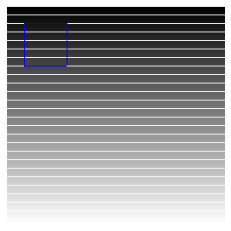

In [204]:
folder = "testsetup/style_loss/"
if not os.path.exists(folder):
    os.mkdir(folder)
w_img = img
w,h = 20, 20
win_size = 50
red = np.zeros(3)
red[2] = 1
for i in range(win_size):
    
    w_img[w,h+i, :] = red
    w_img[w+win_size,h+i, :] = red
    w_img[w+i,h, :] = red
    w_img[w+i,h+win_size, :] = red
plt.imshow(w_img)
plt.axis("off")
plt.imsave(os.path.join(folder, "gradient_image.pdf"), img)

Text(0.5, 1.0, 'style')

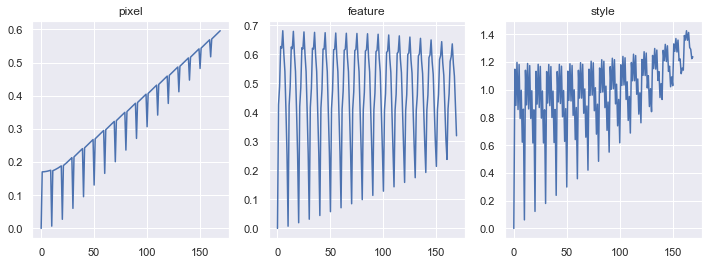

In [197]:
timg = torch.tensor(img)
timg = timg.type(torch.FloatTensor)
timg = torch.movedim(timg, -1, 0)
h, w = 0, 0

shifts = np.arange(0, 230-win_size-10, 1)
style_losses = []
feature_losses = []
pixel_losses = []
show_imgs = False
for s in shifts:
    win = timg[:,h:h+win_size, w:w+win_size]
    slide_win = timg[:,h+s:h+win_size+s, w:w+win_size]
    style_losses.append(style_loss_fn(win, slide_win).item())
    
    win_feature = relu3_3(win.reshape(1,3,win.shape[1],win.shape[2]))
    slide_win_feature = relu3_3(slide_win.reshape(1,3,win.shape[1],win.shape[2]))
    feature_loss = feature_loss_fn(win_feature, slide_win_feature).item()
    feature_losses.append(feature_loss)
    pixel_loss = pixel_loss_fn(win, slide_win).item()
    pixel_losses.append(pixel_loss)    
    
    if show_imgs:
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].imshow(torch.movedim(win, 0, -1))
        ax[1].imshow(torch.movedim(slide_win, 0, -1))
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].plot(shifts, pixel_losses)
ax[0].set_title("pixel")
ax[1].plot(shifts, feature_losses)
ax[1].set_title("feature")
ax[2].plot(shifts, style_losses)
ax[2].set_title("style")

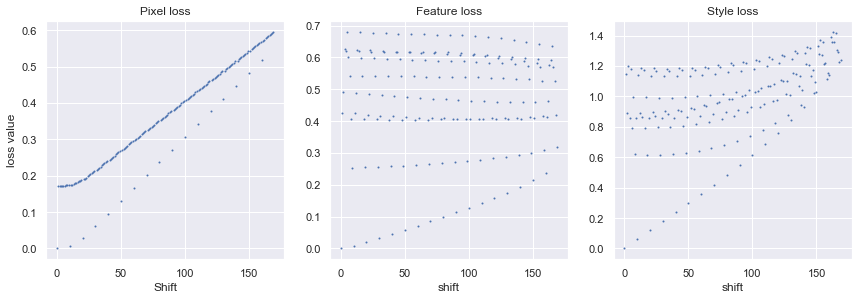

In [199]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
fig.tight_layout()
ax[0].scatter(shifts, pixel_losses, s=1)
ax[0].set_title("Pixel loss")
ax[0].set_ylabel("loss value")
ax[0].set_xlabel("Shift")
ax[1].scatter(shifts, feature_losses, s=1)
ax[1].set_title("Feature loss")
ax[1].set_xlabel("shift")
ax[2].scatter(shifts, style_losses, s=1)
ax[2].set_title("Style loss")
ax[2].set_xlabel("shift")

plt.savefig(os.path.join(folder, "style_feature_pixel.pdf"))